<a href="https://colab.research.google.com/github/eliassalazarb/FisicaComputacional1/blob/main/Actividad6/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Bibliotecas**

In [1]:
# Pronóstico de Series de Tiempo

# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#**Pronóstico de Series de Tiempo**

In [2]:
# Tomar datos del url en formato "raw"
url = 'https://raw.githubusercontent.com/eliassalazarb/FisicaComputacional1/main/Actividad1/25038.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha','Precip','Evap','Tmax','Tmin',]
df_tkt = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python') 

# Hacemos una copia de trabajo y preservamos el dataframe original
df_tkt0 = df_tkt.copy()

# Cambiamos la palabra nulo por un vacío y verificamos
str_Nulo = 'Nulo'
df_tkt1 = df_tkt0.replace(to_replace=str_Nulo, value='', regex=True)

# Convertimos los valores de las variables ambientales a números flotantes y verificamos 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_tkt1[cols] = pd.to_numeric(df_tkt0[cols], errors='coerce')

# Definimos un nuevo dataframe por si hay que regresarse
df_tkt2 = df_tkt1.copy()
df_tkt2['Fecha'].head()

# Se convierte el objeto Fecha a variable fecha que python reconoce
df_tkt2['Fecha'] = pd.to_datetime(df_tkt2['Fecha'], dayfirst=True).copy()

# Añadimos dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.month para extraer el Año y Mes de la Fecha
df_tkt2['Año'] = df_tkt2['Fecha'].dt.year
df_tkt2['Mes'] = df_tkt2['Fecha'].dt.month

# Hacemos una copia del trabajo y es con el que trabajaremos para el análisis de datos
df_meteotkt = df_tkt2.copy()

# Eliminamos la columna de Mes(numérico) y agregamos Mes(caractéres)
df_meteotkt.drop('Mes', axis=1, inplace=True)
df_meteotkt['Mes'] = df_meteotkt['Fecha'].dt.strftime('%b')
# print(df_meteotkt.head())
# print(df_meteotkt.tail())

# Nueva copia del DataFrame para Series de Tiempo
df_meteotkt_ts = df_meteotkt.copy()

# Reemplazamos el índice por la variable 'Fecha' 
df_meteotkt_ts = df_meteotkt.set_index('Fecha')
df_meteotkt_ts.info()

# Seleccionaremos un conjunto de años de 30 años
df_60 = df_meteotkt_ts[(df_meteotkt_ts['Año'] >= 1969) & (df_meteotkt_ts['Año'] < 1999)]
df_90 = df_meteotkt_ts[(df_meteotkt_ts['Año'] >= 1999) & (df_meteotkt_ts['Año'] < 2018)]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17549 entries, 1969-01-15 to 2018-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  17402 non-null  float64
 1   Evap    6167 non-null   float64
 2   Tmax    17412 non-null  float64
 3   Tmin    17379 non-null  float64
 4   Año     17549 non-null  int64  
 5   Mes     17549 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 959.7+ KB


In [3]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar', size=18)
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [4]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1999 a 2018 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2003-03', '2008-2'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2003-03-01,0.0,NaN,25.0,10.0,2003,Mar
2003-03-02,0.0,NaN,27.5,11.5,2003,Mar
2003-03-03,0.0,NaN,28.0,11.0,2003,Mar
2003-03-04,0.0,NaN,30.0,11.5,2003,Mar
2003-03-05,0.0,NaN,29.0,10.0,2003,Mar


#**Temperatura Máxima**

In [5]:
# Vemos su encabezado
ts_90['Tmax'].head()

Fecha
2003-03-01    25.0
2003-03-02    27.5
2003-03-03    28.0
2003-03-04    30.0
2003-03-05    29.0
Name: Tmax, dtype: float64

In [7]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico
ts_test_TMX = ts_90['Tmax'].copy()

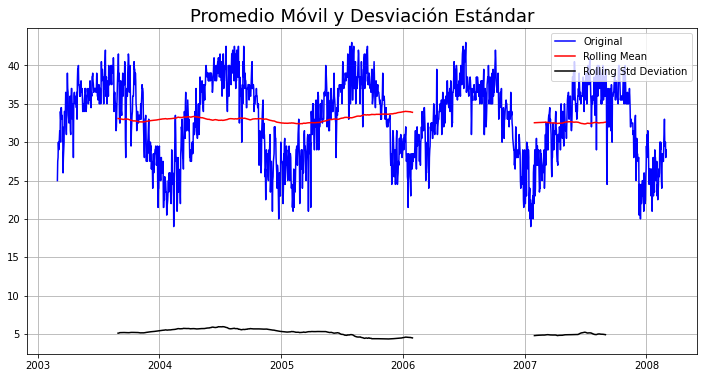

Resultados de la Prueba de Dickey-Fuller:


MissingDataError: ignored

In [8]:

# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test_TMX)

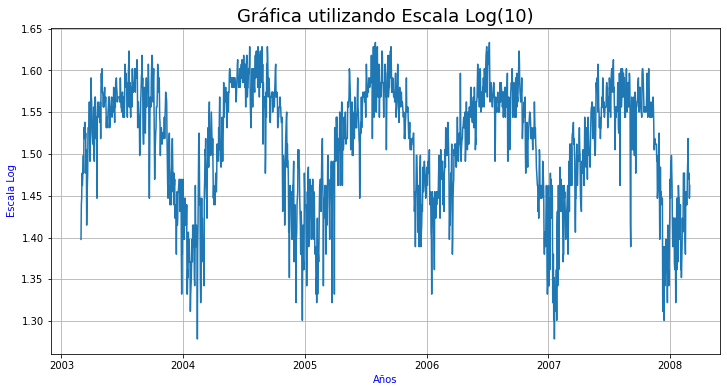

In [9]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_TMX_log = np.log10(ts_test_TMX)
plt.plot(ts_test_TMX_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)',size=18)
plt.grid()
plt.show();

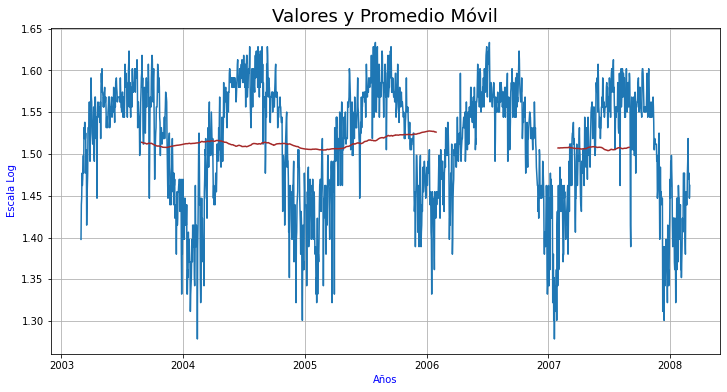

In [10]:
moving_avg_TMX = ts_test_TMX_log.rolling(365, center=True).mean()
plt.plot(ts_test_TMX_log)
plt.plot(moving_avg_TMX, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil', size=18)
plt.grid()
plt.show();

In [11]:
ts_test_log_moving_ave_diff_TMX = ts_test_TMX_log - moving_avg_TMX 
ts_test_log_moving_ave_diff_TMX.head()

Fecha
2003-03-01   NaN
2003-03-02   NaN
2003-03-03   NaN
2003-03-04   NaN
2003-03-05   NaN
Name: Tmax, dtype: float64

In [12]:
ts_test_log_moving_ave_diff_TMX.dropna(inplace=True)
ts_test_log_moving_ave_diff_TMX.head()

Fecha
2003-08-30    0.082643
2003-08-31    0.104094
2003-09-01    0.065943
2003-09-02    0.077358
2003-09-03    0.011604
Name: Tmax, dtype: float64

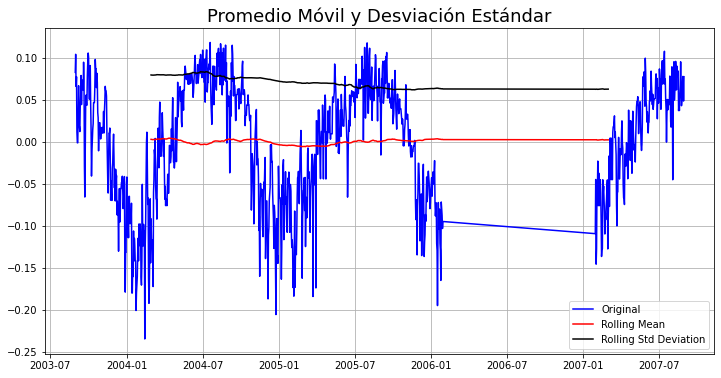

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -1.812627
p-value                           0.374211
#Lags Used                       16.000000
Number of Observations Used    1081.000000
Critical Value (1%)              -3.436414
Critical Value (5%)              -2.864217
Critical Value (10%)             -2.568196
dtype: float64


In [13]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff_TMX)

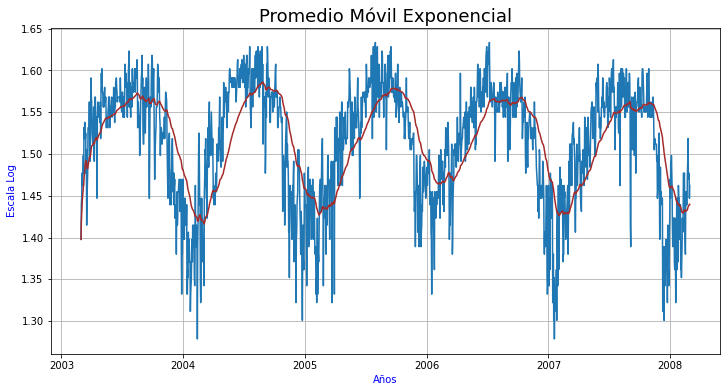

In [14]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg_TMX = ts_test_TMX_log.ewm(halflife=30).mean()
plt.plot(ts_test_TMX_log)
plt.plot(EWM_avg_TMX, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial', size=18)
plt.grid()
plt.show();

In [15]:
EWM_avg_TMX.head()

Fecha
2003-03-01    1.397940
2003-03-02    1.418875
2003-03-03    1.428522
2003-03-04    1.441096
2003-03-05    1.445555
Name: Tmax, dtype: float64

In [16]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff_TMX = ts_test_TMX_log - EWM_avg_TMX

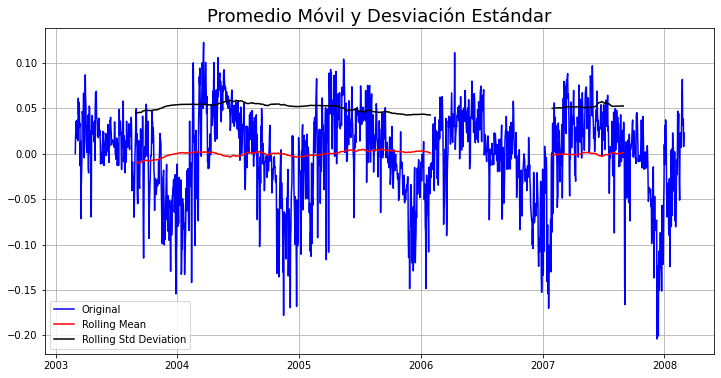

Resultados de la Prueba de Dickey-Fuller:


MissingDataError: ignored

In [17]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff_TMX)

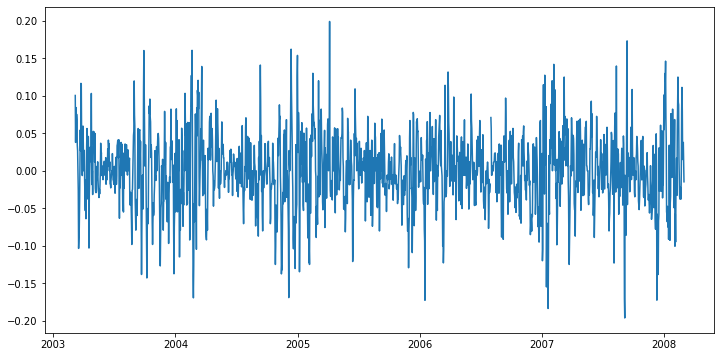

In [18]:

# Diferenciamos usando la función df.shift()
ts_test_log_diff_TMX = ts_test_TMX_log - ts_test_TMX_log.shift(periods=7)
plt.plot(ts_test_log_diff_TMX);

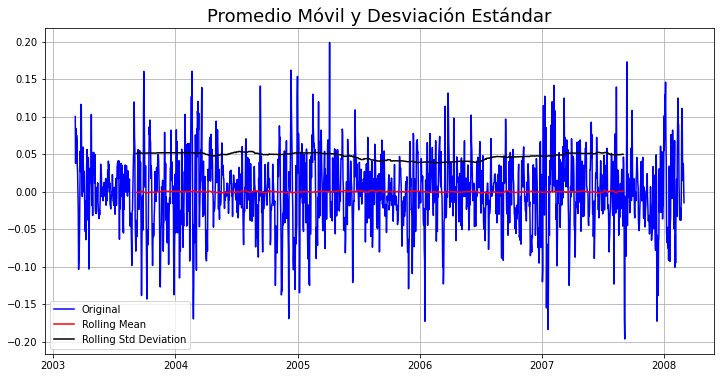

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.471915e+00
p-value                        1.469855e-13
#Lags Used                     2.400000e+01
Number of Observations Used    1.793000e+03
Critical Value (1%)           -3.434002e+00
Critical Value (5%)           -2.863153e+00
Critical Value (10%)          -2.567629e+00
dtype: float64


In [19]:
# Probamos la estacionaridad
ts_test_log_diff_TMX.dropna(inplace=True)
test_stationarity(ts_test_log_diff_TMX)

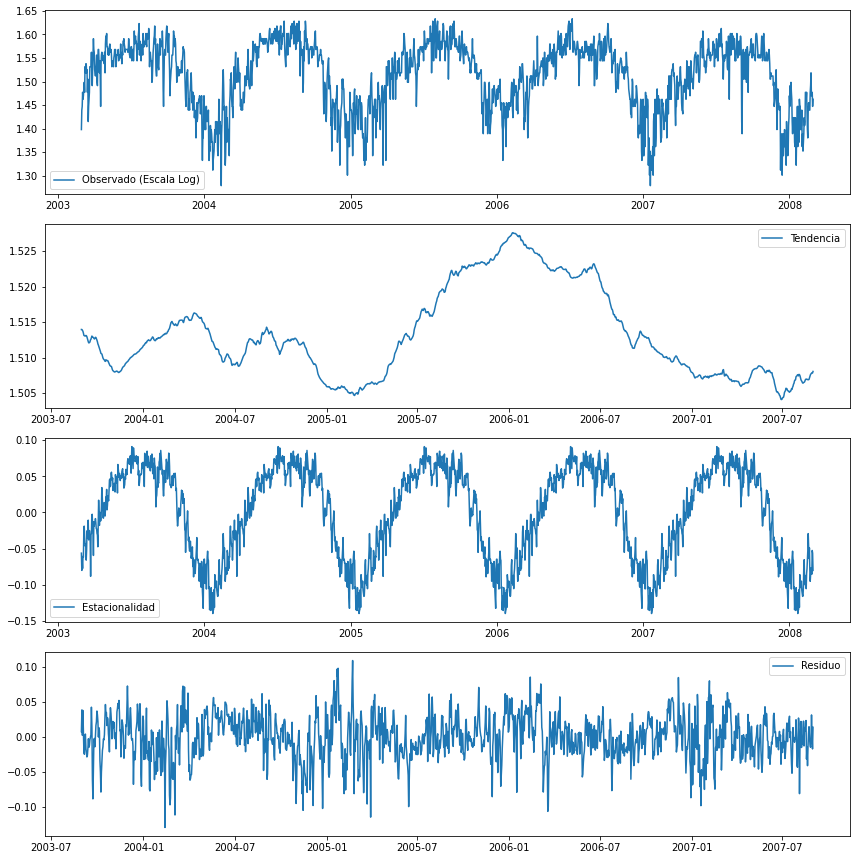

In [20]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition_TMX = sm.tsa.seasonal_decompose(ts_test_TMX_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend_TMX = decomposition_TMX.trend
seasonal_TMX = decomposition_TMX.seasonal
residue_TMX = decomposition_TMX.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_TMX_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_TMX, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_TMX, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue_TMX, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

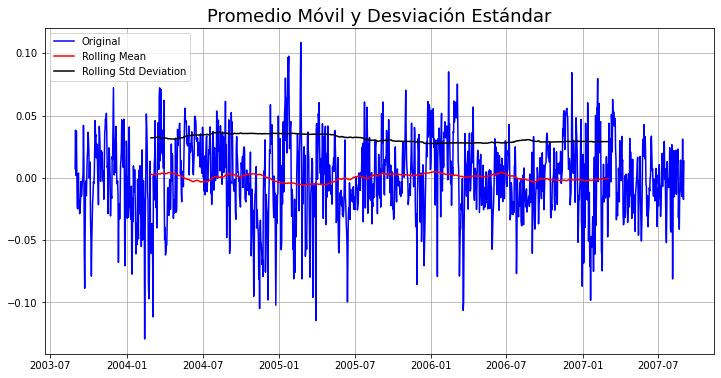

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.144069e+01
p-value                        6.189119e-21
#Lags Used                     4.000000e+00
Number of Observations Used    1.458000e+03
Critical Value (1%)           -3.434843e+00
Critical Value (5%)           -2.863524e+00
Critical Value (10%)          -2.567826e+00
dtype: float64


In [21]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose_TMX = residue_TMX 
ts_test_log_decompose_TMX.dropna(inplace=True)
test_stationarity(ts_test_log_decompose_TMX)

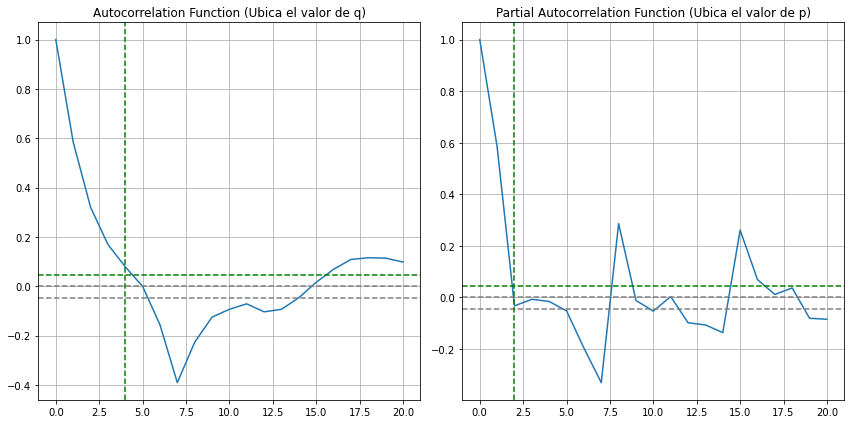

In [22]:
# Aplicamos ARIMA

lag_acf_TMX = acf(ts_test_log_diff_TMX, nlags=20)
lag_pacf_TMX = pacf(ts_test_log_diff_TMX, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf_TMX)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf_TMX)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1825
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3794.613
Method:                       css-mle   S.D. of innovations              0.030
Date:                Mon, 22 Feb 2021   AIC                          -7581.226
Time:                        21:33:21   BIC                          -7559.189
Sample:                             1   HQIC                         -7573.097
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.767e-05      0.001      0.055      0.956      -0.001       0.001
ar.L1.D.Tmax    -0.2458      0.023    -10.654      0.000      -0.291      -0.201
ar.L2.D.Tmax    -0.1701      0.023     -7.37

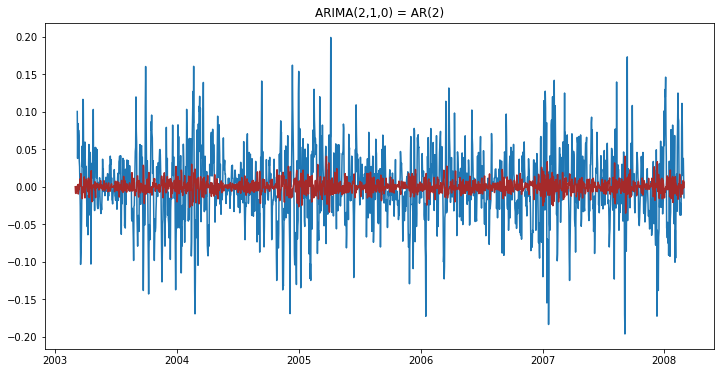

In [23]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model_TMX = ARIMA(ts_test_TMX_log, order=(2,1,0), missing='drop')
results_AR_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_AR_TMX.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR_TMX.summary())

In [24]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model_TMX = ARIMA(ts_test_TMX_log, order=(0,1,5), missing='drop')
results_MA_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_MA_TMX.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA_TMX.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: ignored

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1825
Model:                 ARIMA(2, 1, 5)   Log Likelihood                3871.796
Method:                       css-mle   S.D. of innovations              0.029
Date:                Mon, 22 Feb 2021   AIC                          -7725.592
Time:                        21:33:37   BIC                          -7676.008
Sample:                             1   HQIC                         -7707.302
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.226e-06      0.000      0.007      0.995      -0.000       0.000
ar.L1.D.Tmax    -0.2536      0.253     -1.002      0.316      -0.750       0.242
ar.L2.D.Tmax     0.5234      0.199      2.63

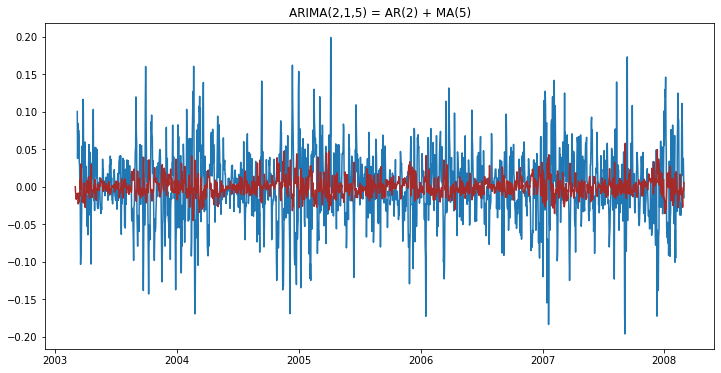

In [25]:
# Modelo ARIMA(p): (p,d,q) = (2,1,5) 
model_TMX = ARIMA(ts_test_TMX_log, order=(2,1,5), missing='drop')
results_ARIMA_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_ARIMA_TMX.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA_TMX.summary());

In [26]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff_TMX = pd.Series(results_ARIMA_TMX.fittedvalues, copy=True)
print(predictions_ARIMA_diff_TMX)

Fecha
2003-03-02    0.000001
2003-03-03   -0.008580
2003-03-04   -0.008989
2003-03-05   -0.016752
2003-03-06   -0.010426
                ...   
2008-02-25   -0.027285
2008-02-26   -0.006730
2008-02-27   -0.005619
2008-02-28   -0.005622
2008-02-29    0.005603
Length: 1825, dtype: float64


In [27]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log_TMX = pd.Series(ts_test_TMX_log, index = ts_test_TMX_log.index)
predictions_ARIMA_log_TMX = predictions_ARIMA_log_TMX.add(predictions_ARIMA_diff_TMX)
print(predictions_ARIMA_log_TMX.head())
print(predictions_ARIMA_log_TMX.tail())

Fecha
2003-03-01         NaN
2003-03-02    1.439334
2003-03-03    1.438578
2003-03-04    1.468132
2003-03-05    1.445646
dtype: float64
Fecha
2008-02-25    1.442537
2008-02-26    1.463092
2008-02-27    1.471502
2008-02-28    1.441536
2008-02-29    1.468001
dtype: float64


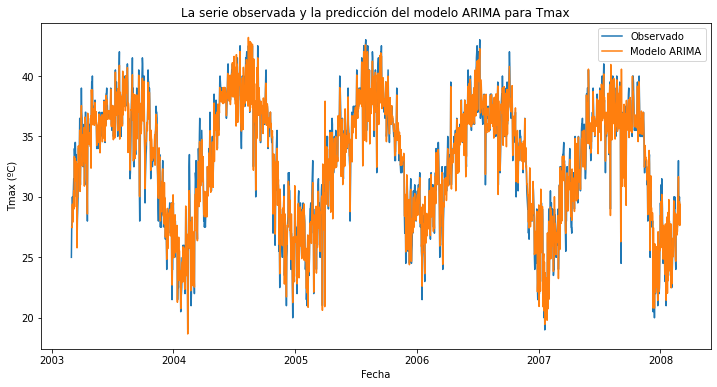

In [28]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA_TMX = 10**(predictions_ARIMA_log_TMX)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test_TMX, label='Observado');
plt.plot(predictions_ARIMA_TMX, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [29]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE_TMX = np.sqrt(np.mean((predictions_ARIMA_TMX - ts_test_TMX)**2))
print('RMSE:', RMSE_TMX)

RMSE: 0.859517719788535


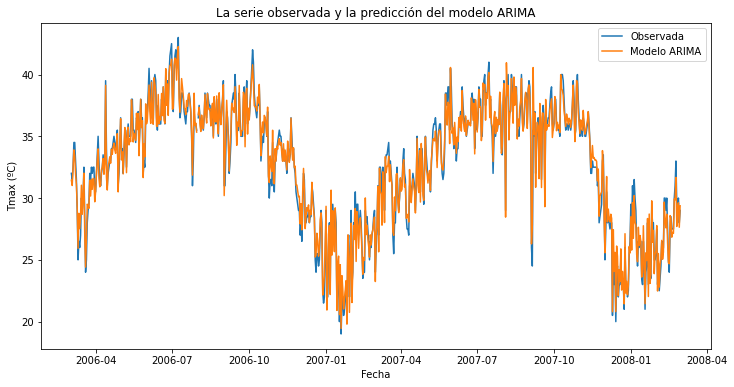

In [30]:
# Graficamos sólo los útimos datos de las series 
ts_test_last_TMX = ts_test_TMX.tail(730)
predictions_ARIMA_last_TMX = predictions_ARIMA_TMX.tail(730)
plt.plot(ts_test_last_TMX, label='Observada');
plt.plot(predictions_ARIMA_last_TMX, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

#**Temperatura Mínima**

In [31]:
# Convertimos Tmin de ºC a ºK para poder usar escala logaritmica

C = 273.15
ts_90['TK'] = df_90['Tmin'] + C
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes,TK
Fecha,,,,,,,
2003-03-01,0.0,NaN,25.0,10.0,2003,Mar,283.15
2003-03-02,0.0,NaN,27.5,11.5,2003,Mar,284.65
2003-03-03,0.0,NaN,28.0,11.0,2003,Mar,284.15
2003-03-04,0.0,NaN,30.0,11.5,2003,Mar,284.65
2003-03-05,0.0,NaN,29.0,10.0,2003,Mar,283.15


In [32]:
# Vemos su encabezado
ts_90['TK'].head()

Fecha
2003-03-01    283.15
2003-03-02    284.65
2003-03-03    284.15
2003-03-04    284.65
2003-03-05    283.15
Name: TK, dtype: float64

In [34]:
# Definimos la Serie de Tiempo con Tmin que vamos a estudiar, le damos un nombre genérico
ts_test_TMN = ts_90['TK'].copy()

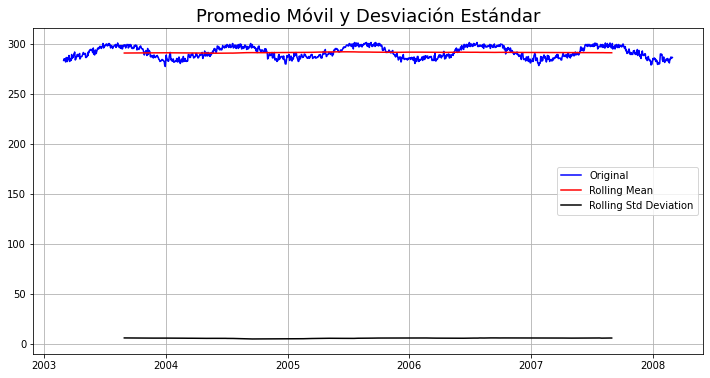

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.358947
p-value                           0.153660
#Lags Used                       13.000000
Number of Observations Used    1813.000000
Critical Value (1%)              -3.433962
Critical Value (5%)              -2.863136
Critical Value (10%)             -2.567619
dtype: float64


In [35]:
# Realizamos la Prueba de Estacionaridad de Tmin
test_stationarity(ts_test_TMN)

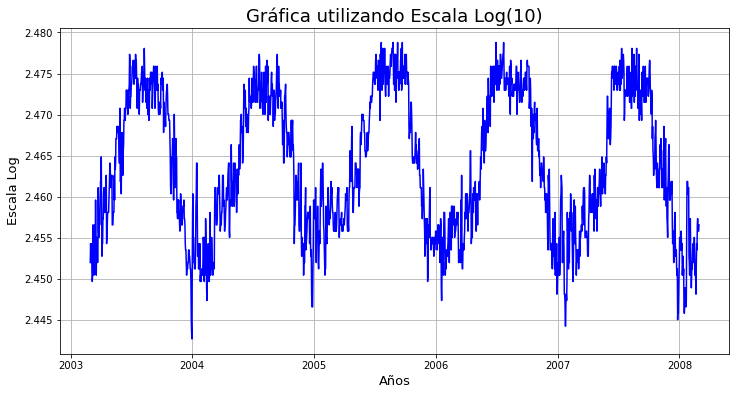

In [36]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_TMN_log = np.log10(ts_test_TMN)
plt.plot(ts_test_TMN_log, color='blue')
plt.xlabel('Años',size=13)
plt.ylabel('Escala Log',size=13)
plt.title('Gráfica utilizando Escala Log(10)',size=18)
plt.grid()
plt.show();

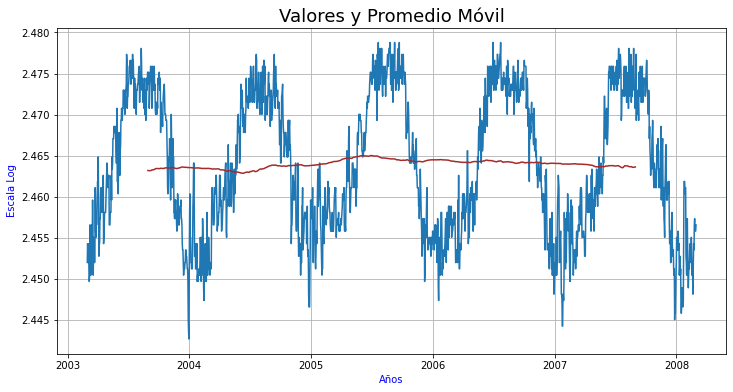

In [37]:
moving_avg_TMN = ts_test_TMN_log.rolling(365, center=True).mean()
plt.plot(ts_test_TMN_log)
plt.plot(moving_avg_TMN, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil', size=18)
plt.grid()
plt.show();

In [38]:
ts_test_log_moving_ave_diff_TMN = ts_test_TMN_log - moving_avg_TMN 
ts_test_log_moving_ave_diff_TMN.head()

Fecha
2003-03-01   NaN
2003-03-02   NaN
2003-03-03   NaN
2003-03-04   NaN
2003-03-05   NaN
Name: TK, dtype: float64

In [39]:
ts_test_log_moving_ave_diff_TMN.dropna(inplace=True)
ts_test_log_moving_ave_diff_TMN.head()

Fecha
2003-08-30    0.011956
2003-08-31    0.011224
2003-09-01    0.010503
2003-09-02    0.011966
2003-09-03    0.007592
Name: TK, dtype: float64

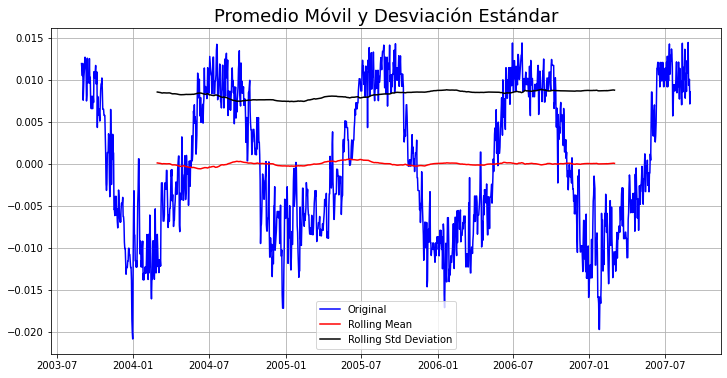

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.262987
p-value                           0.184183
#Lags Used                       10.000000
Number of Observations Used    1452.000000
Critical Value (1%)              -3.434862
Critical Value (5%)              -2.863533
Critical Value (10%)             -2.567831
dtype: float64


In [40]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff_TMN)

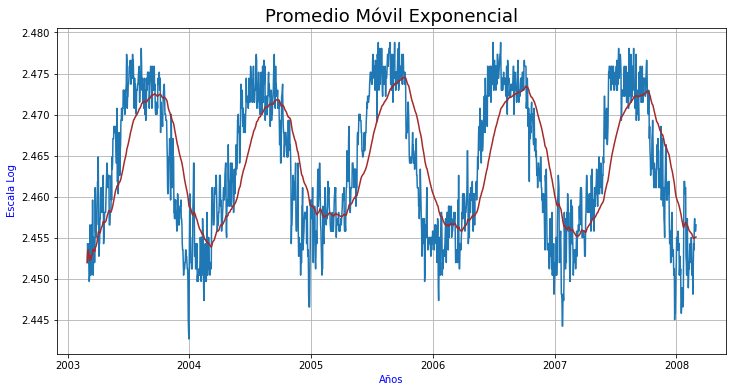

In [41]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg_TMN = ts_test_TMN_log.ewm(halflife=30).mean()
plt.plot(ts_test_TMN_log)
plt.plot(EWM_avg_TMN, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial', size=18)
plt.grid()
plt.show();

In [42]:
EWM_avg_TMX.head()

Fecha
2003-03-01    1.397940
2003-03-02    1.418875
2003-03-03    1.428522
2003-03-04    1.441096
2003-03-05    1.445555
Name: Tmax, dtype: float64

In [43]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff_TMN = ts_test_TMN_log - EWM_avg_TMN

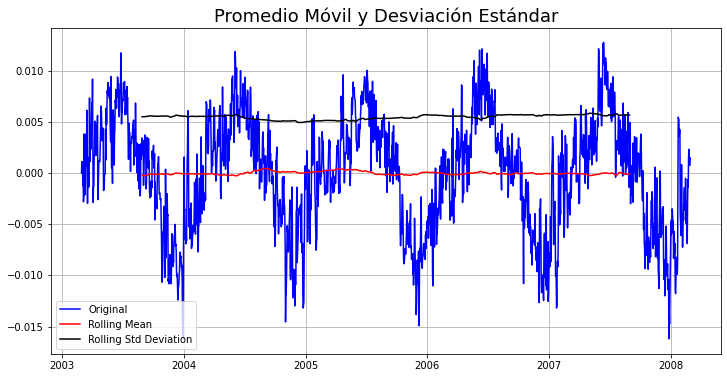

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.932989
p-value                           0.041644
#Lags Used                       16.000000
Number of Observations Used    1810.000000
Critical Value (1%)              -3.433968
Critical Value (5%)              -2.863138
Critical Value (10%)             -2.567621
dtype: float64


In [44]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff_TMN)

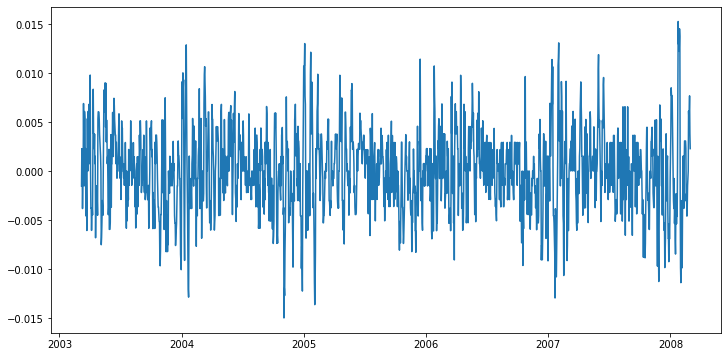

In [45]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff_TMN = ts_test_TMN_log - ts_test_TMN_log.shift(periods=7)
plt.plot(ts_test_log_diff_TMN);

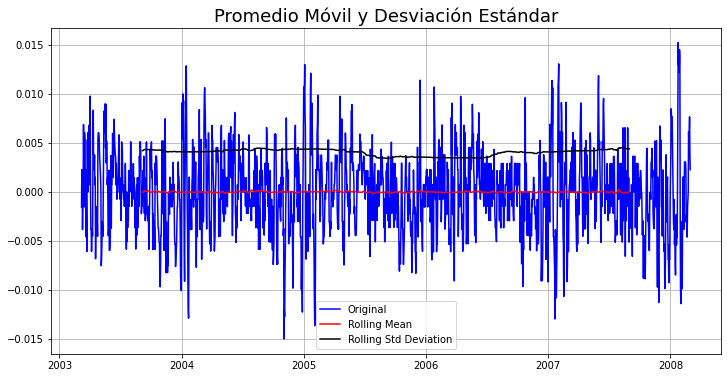

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -7.126111e+00
p-value                        3.616733e-10
#Lags Used                     2.200000e+01
Number of Observations Used    1.797000e+03
Critical Value (1%)           -3.433994e+00
Critical Value (5%)           -2.863150e+00
Critical Value (10%)          -2.567627e+00
dtype: float64


In [46]:
# Probamos la estacionaridad
ts_test_log_diff_TMN.dropna(inplace=True)
test_stationarity(ts_test_log_diff_TMN)

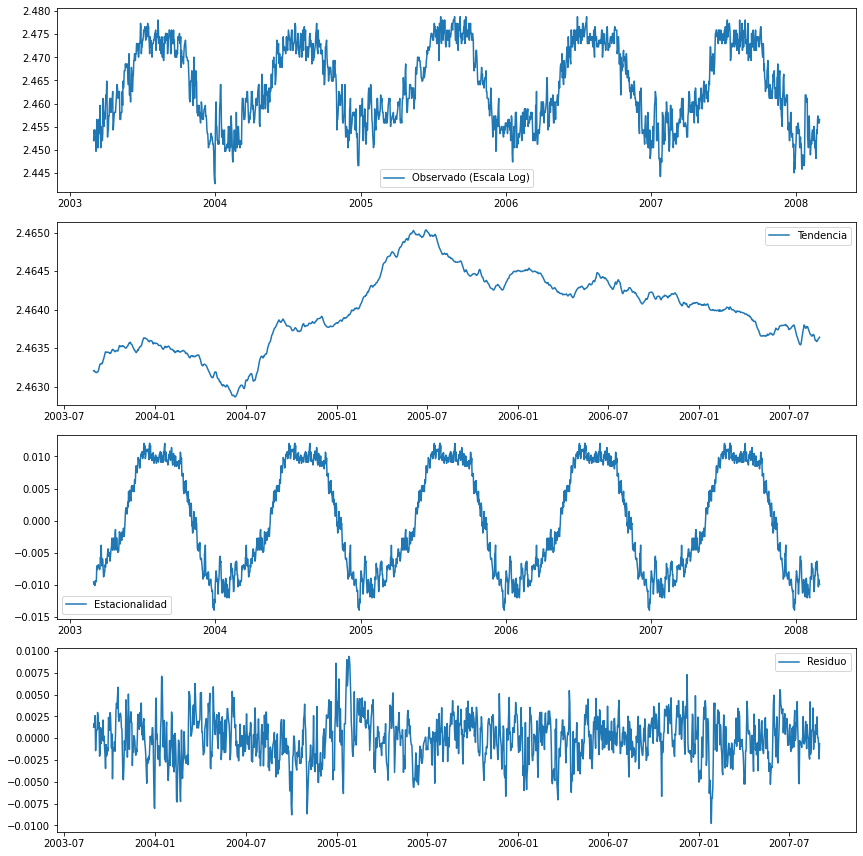

In [47]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition_TMN = sm.tsa.seasonal_decompose(ts_test_TMN_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend_TMN = decomposition_TMN.trend
seasonal_TMN = decomposition_TMN.seasonal
residue_TMN = decomposition_TMN.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_TMN_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_TMN, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_TMN, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue_TMN, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

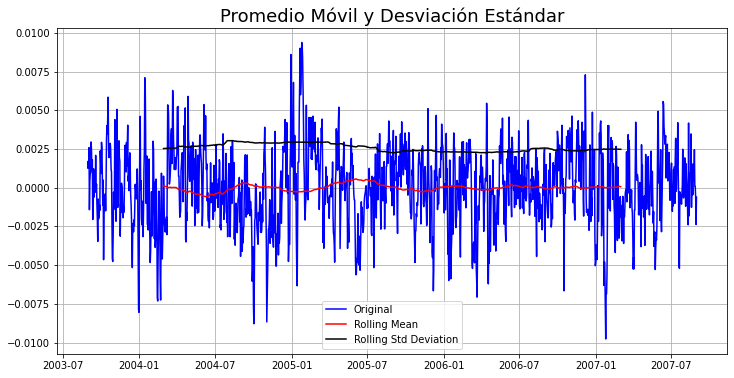

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.678173e+01
p-value                        1.262610e-29
#Lags Used                     0.000000e+00
Number of Observations Used    1.462000e+03
Critical Value (1%)           -3.434831e+00
Critical Value (5%)           -2.863519e+00
Critical Value (10%)          -2.567824e+00
dtype: float64


In [48]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose_TMN = residue_TMN 
ts_test_log_decompose_TMN.dropna(inplace=True)
test_stationarity(ts_test_log_decompose_TMN)

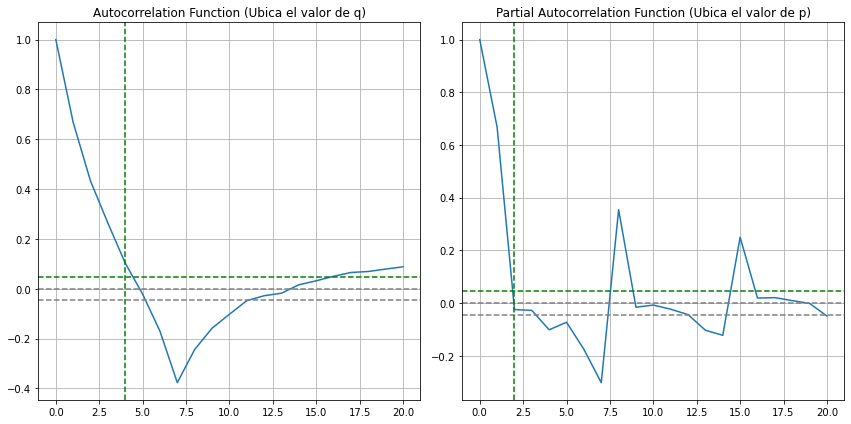

In [49]:
# Aplicamos ARIMA

lag_acf_TMN = acf(ts_test_log_diff_TMN, nlags=20)
lag_pacf_TMN = pacf(ts_test_log_diff_TMN, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf_TMN)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf_TMN)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D.TK   No. Observations:                 1826
Model:                 ARIMA(2, 1, 0)   Log Likelihood                8477.246
Method:                       css-mle   S.D. of innovations              0.002
Date:                Mon, 22 Feb 2021   AIC                         -16946.492
Time:                        21:35:47   BIC                         -16924.452
Sample:                    03-02-2003   HQIC                        -16938.362
                         - 02-29-2008                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.15e-06   4.16e-05      0.052      0.959   -7.93e-05    8.36e-05
ar.L1.D.TK    -0.1683      0.023     -7.270      0.000      -0.214      -0.123
ar.L2.D.TK    -0.1447      0.023     -6.249      0.0

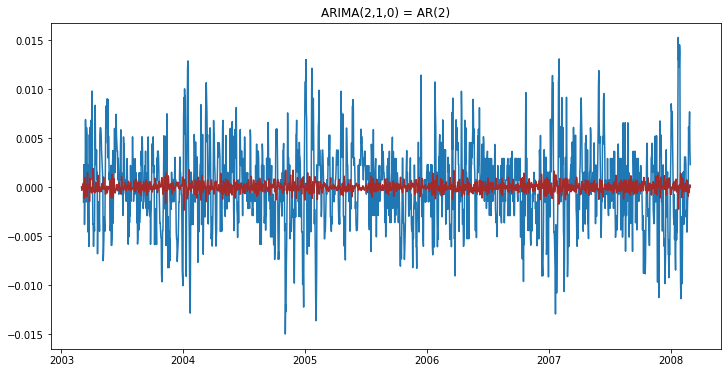

In [50]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model_TMN = ARIMA(ts_test_TMN_log, order=(2,1,0), missing='drop')
results_AR_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_AR_TMN.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR_TMN.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D.TK   No. Observations:                 1826
Model:                 ARIMA(0, 1, 5)   Log Likelihood                8524.930
Method:                       css-mle   S.D. of innovations              0.002
Date:                Mon, 22 Feb 2021   AIC                         -17035.861
Time:                        21:35:54   BIC                         -16997.292
Sample:                    03-02-2003   HQIC                        -17021.634
                         - 02-29-2008                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.491e-06   2.01e-05      0.074      0.941   -3.79e-05    4.09e-05
ma.L1.D.TK    -0.2285      0.023     -9.772      0.000      -0.274      -0.183
ma.L2.D.TK    -0.1732      0.024     -7.266      0.0

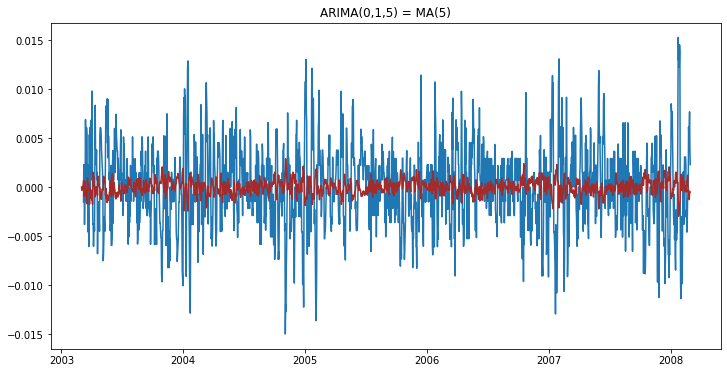

In [51]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model_TMN = ARIMA(ts_test_TMN_log, order=(0,1,5), missing='drop')
results_MA_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_MA_TMN.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA_TMN.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                   D.TK   No. Observations:                 1826
Model:                 ARIMA(2, 1, 5)   Log Likelihood                8524.996
Method:                       css-mle   S.D. of innovations              0.002
Date:                Mon, 22 Feb 2021   AIC                         -17031.993
Time:                        21:36:01   BIC                         -16982.404
Sample:                    03-02-2003   HQIC                        -17013.701
                         - 02-29-2008                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.471e-06      2e-05      0.074      0.941   -3.78e-05    4.07e-05
ar.L1.D.TK    -0.4527        nan        nan        nan         nan         nan
ar.L2.D.TK     0.1624        nan        nan        n

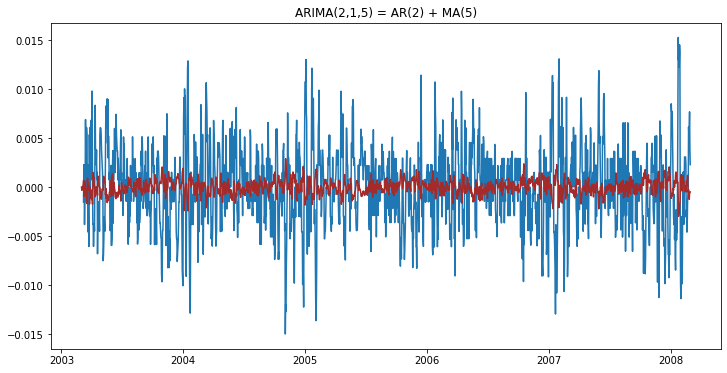

In [52]:
# Modelo ARIMA(p): (p,d,q) = (2,1,5) 
model_TMN = ARIMA(ts_test_TMN_log, order=(2,1,5), missing='drop')
results_ARIMA_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_ARIMA_TMN.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA_TMN.summary());

In [53]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff_TMN = pd.Series(results_ARIMA_TMN.fittedvalues, copy=True)
print(predictions_ARIMA_diff_TMN)

Fecha
2003-03-02    0.000001
2003-03-03   -0.000334
2003-03-04   -0.000203
2003-03-05   -0.000251
2003-03-06    0.000105
                ...   
2008-02-25   -0.001112
2008-02-26   -0.001259
2008-02-27   -0.000617
2008-02-28   -0.000590
2008-02-29   -0.000503
Length: 1826, dtype: float64


In [54]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log_TMN = pd.Series(ts_test_TMN_log, index = ts_test_TMN_log.index)
predictions_ARIMA_log_TMN = predictions_ARIMA_log_TMN.add(predictions_ARIMA_diff_TMN)
print(predictions_ARIMA_log_TMN.head())
print(predictions_ARIMA_log_TMN.tail())

Fecha
2003-03-01         NaN
2003-03-02    2.454313
2003-03-03    2.453214
2003-03-04    2.454108
2003-03-05    2.451766
dtype: float64
Fecha
2008-02-25    2.456240
2008-02-26    2.454576
2008-02-27    2.455218
2008-02-28    2.455244
2008-02-29    2.456091
dtype: float64


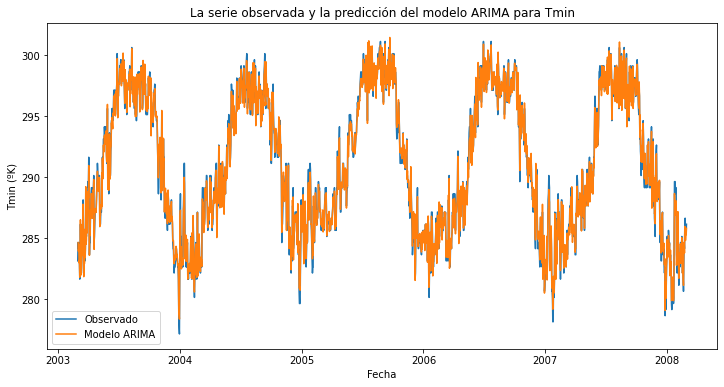

In [55]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA_TMN = 10**(predictions_ARIMA_log_TMN)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test_TMN, label='Observado');
plt.plot(predictions_ARIMA_TMN, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºK)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');

In [56]:
print(predictions_ARIMA_TMN)

Fecha
2003-03-01           NaN
2003-03-02    284.650964
2003-03-03    283.931602
2003-03-04    284.517041
2003-03-05    282.986691
                 ...    
2008-02-25    285.917060
2008-02-26    284.823405
2008-02-27    285.244739
2008-02-28    285.262337
2008-02-29    285.818879
Length: 1827, dtype: float64


In [57]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE_TMN = np.sqrt(np.mean((predictions_ARIMA_TMN - ts_test_TMN)**2))
print('RMSE:', RMSE_TMN)

RMSE: 0.4790560738326544


In [58]:
# Convertimos temperaturas de ºK a ºC

C = 273.15

predictions_ARIMA_TMN_C = predictions_ARIMA_TMN - C
print(predictions_ARIMA_TMN_C.head())

ts_test_TMN_C = ts_test_TMN - C
print(ts_test_TMN_C.head())

Fecha
2003-03-01          NaN
2003-03-02    11.500964
2003-03-03    10.781602
2003-03-04    11.367041
2003-03-05     9.836691
dtype: float64
Fecha
2003-03-01    10.0
2003-03-02    11.5
2003-03-03    11.0
2003-03-04    11.5
2003-03-05    10.0
Name: TK, dtype: float64


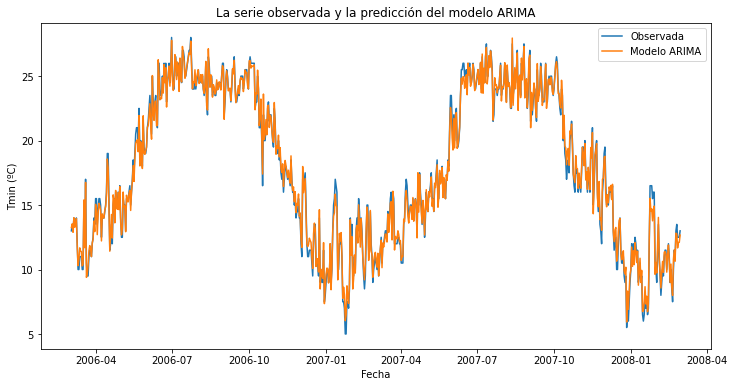

In [59]:
# Graficamos sólo los útimos datos de las series 
ts_test_last_TMN_C = ts_test_TMN_C.tail(730)
predictions_ARIMA_last_TMN = predictions_ARIMA_TMN_C.tail(730)
plt.plot(ts_test_last_TMN_C, label='Observada');
plt.plot(predictions_ARIMA_last_TMN, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');